In [20]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

mkl.set_num_threads(4)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [21]:
# arrange 2D matrices as tiles (takes 4D `examples` tensor with dims: rows x cols x tile_height x tile_width)
def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    space_between_tiles = 2
    img_matrix = np.empty([rows_count * (tile_height + space_between_tiles) + space_between_tiles, cols_count * (tile_width + space_between_tiles)+ space_between_tiles], dtype=np.float32)
    img_matrix.fill(np.nan)
    for r in range(rows_count):
        for c in range(cols_count):
            x = r * (tile_height+space_between_tiles)
            y = c * (tile_width+space_between_tiles)
            img_matrix[x: x + tile_height, y: y + tile_width] = examples[r,c]
    return img_matrix

## MNIST Dataset

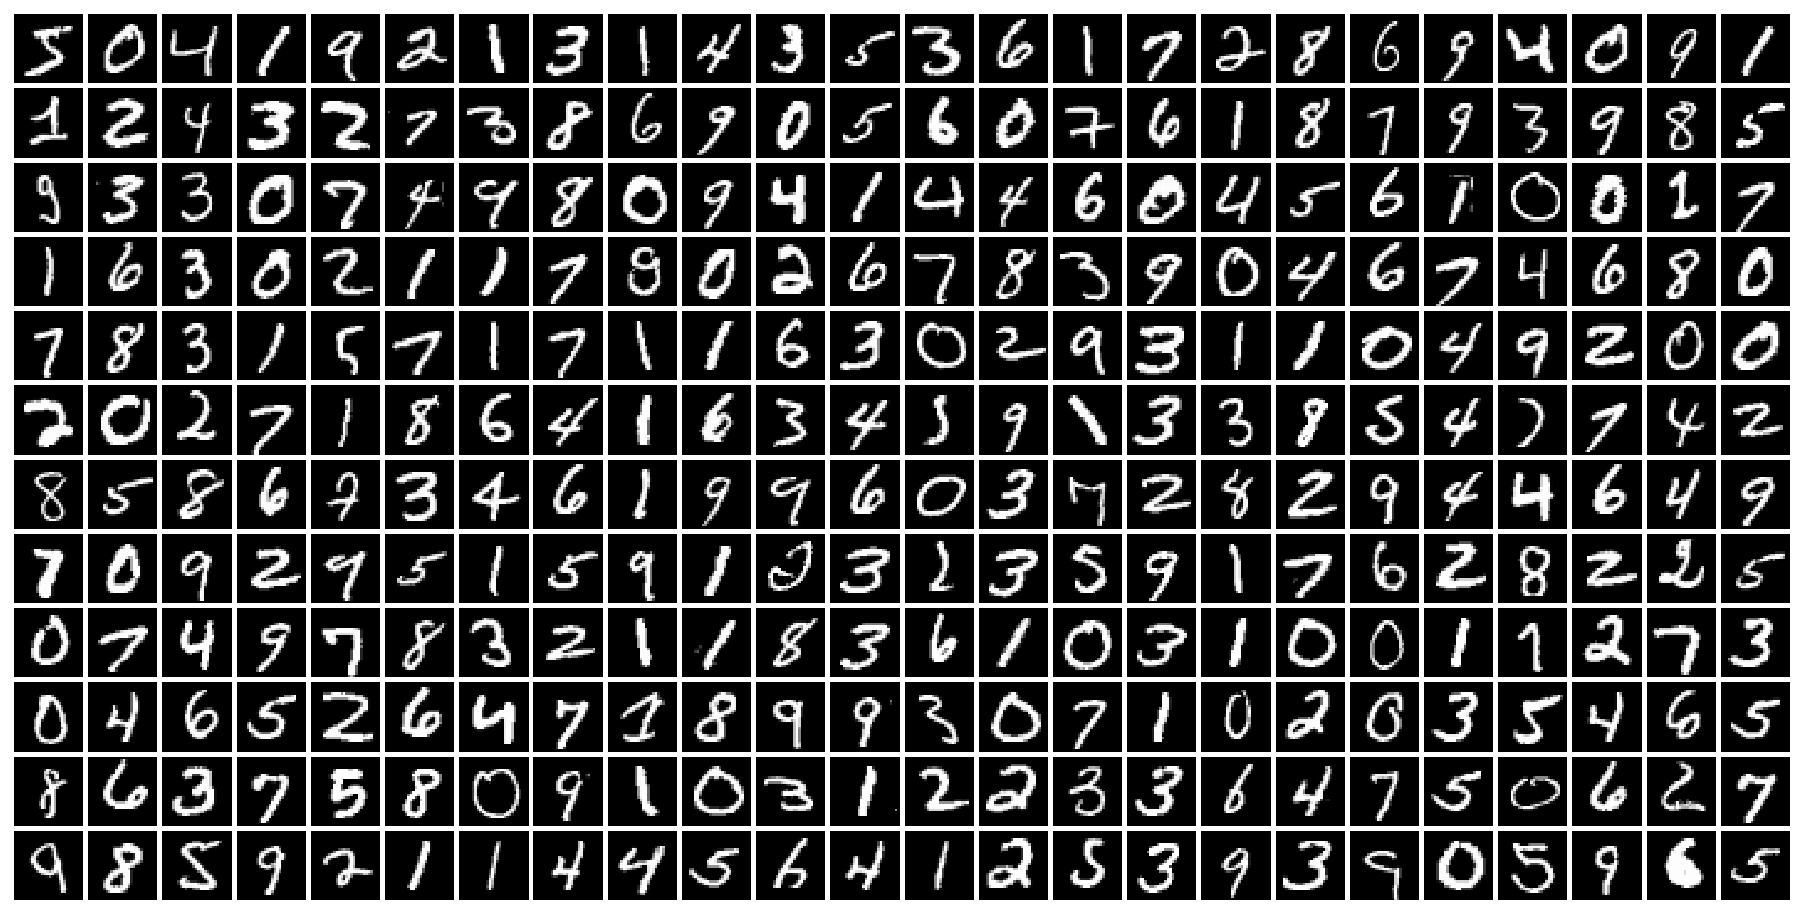

In [22]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
img = tiles(digits)

plt.matshow(img, cmap='gray', interpolation='none')
plt.axis('off')
plt.show()

In [23]:
X = mnist.train_images().astype(np.float32) / 255.0
y = mnist.train_labels()
X.shape

(60000, 28, 28)

Reshape `X` so that the last two dimensions are collapsed into single dimension.

In [24]:
X = np.reshape(X, newshape=(X.shape[0], -1))

In [25]:
X.shape

(60000, 784)

## Visualizing the distribution of MNIST digits

Add a scatter plot to `plot`, which:
* displys the first two dimensions of `X`,
* includes only these elements from `X` for which `y == i` (i.e. elements from the i-th class),
* includes label (i.e. `i`) in the legend.


In [37]:
def plot_2d_mnist_scatter(X, y):
    print(X.shape, y.shape)
    fig, plot = plt.subplots()
    fig.set_size_inches(16, 16)
    plt.prism()

    for i in range(10):
        digit_indeces = y == i
        X_same_class = X[digit_indeces]
        dim1 = X_same_class[:,0]
        dim2 = X_same_class[:,1]
        plot.scatter(dim1, dim2, label=i )

    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend()
    plt.show()

### Principal Component Analysis (PCA)

In [27]:
SAMPLES_LIMIT = 2000
X_small = X[:SAMPLES_LIMIT]
y_small = y[:SAMPLES_LIMIT]

Use PCA function to embed `X_small` in two dimensions. Store the result in `X_pca_embedded`.

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca_embedded = pca.fit_transform(X_small, y_small)

In [29]:
X_pca_embedded.shape

(2000, 2)

(2000, 2) (2000,)


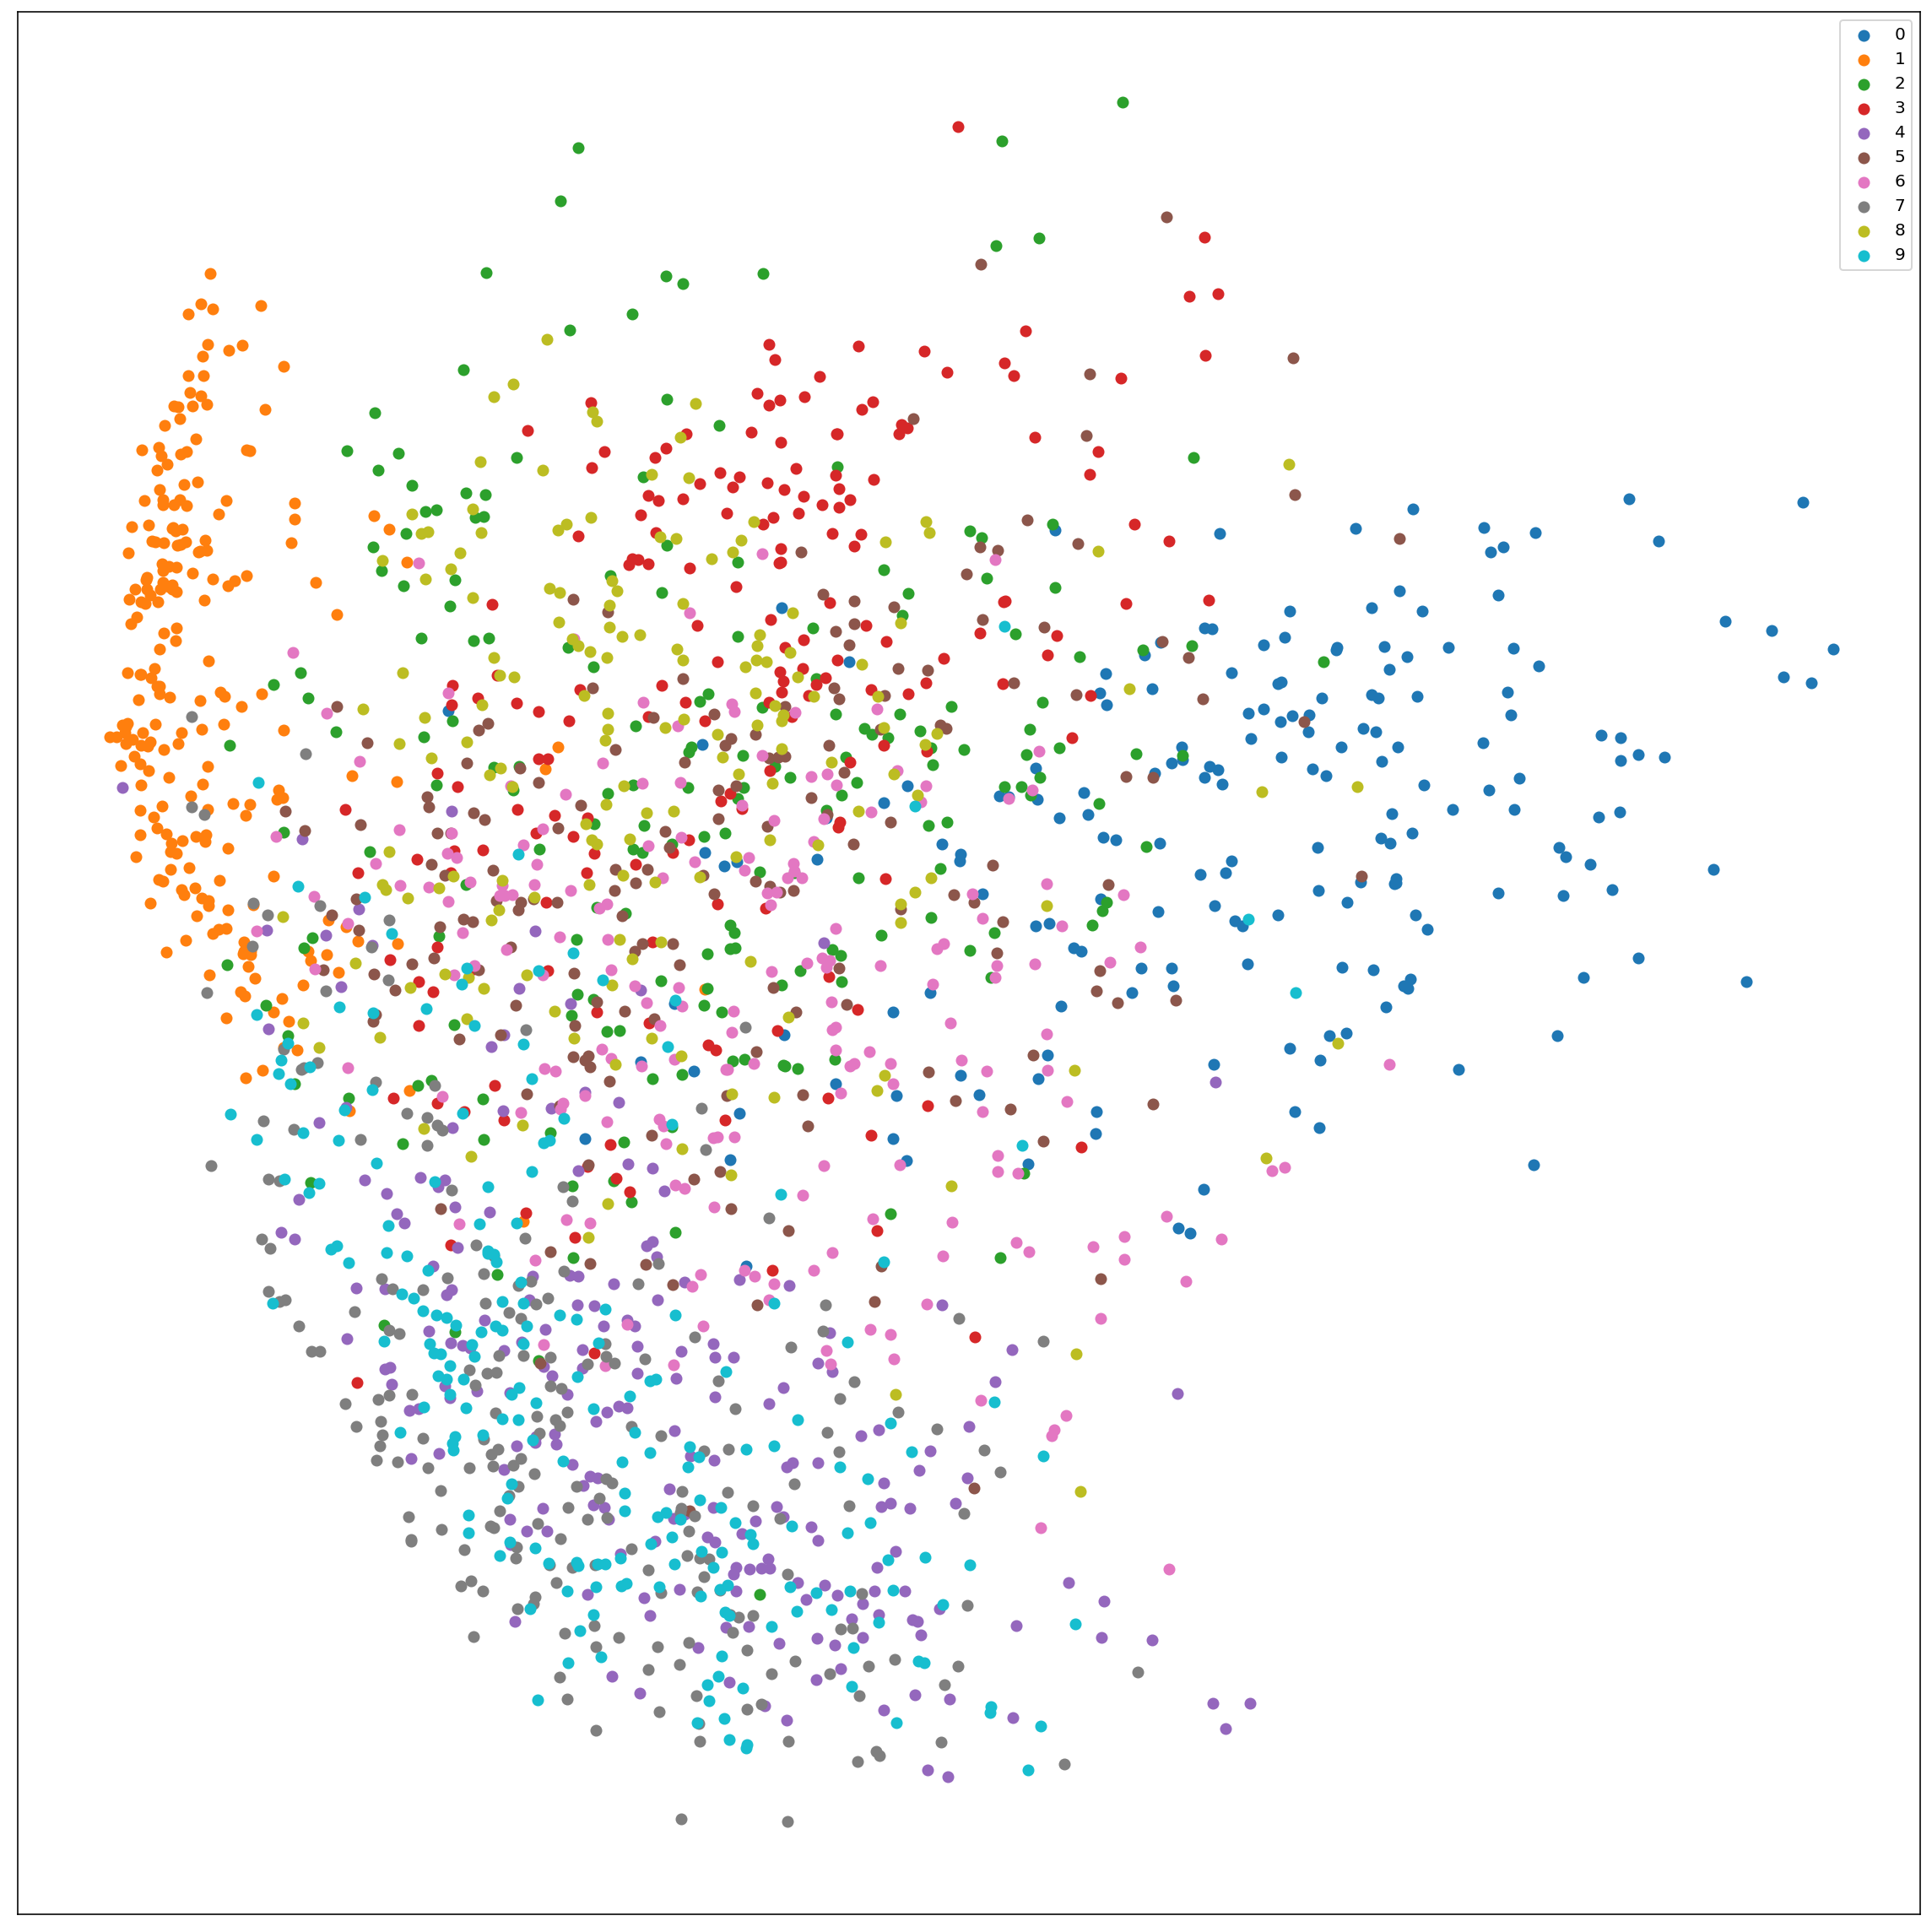

In [38]:
plot_2d_mnist_scatter(X_pca_embedded, y_small)

### T-distributed Stochastic Neighbour Embedding (T-SNE)

Make sure to have a look on this increadible [article on T-SNE](https://distill.pub/2016/misread-tsne/).

Use `T-SNE` function to embed `X_small` in two dimensions. Store the result in `X_tsne_embedded`. <BR>
Use:
 * `n_iter=500` argument to limit the number of T-SNE iterations, 
 * `verbose=2` argument to see a verbose output during embedding.

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=500, verbose=2)
X_tsne_embedded = tsne.fit_transform(X_small)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.061s...
[t-SNE] Computed neighbors for 2000 samples in 6.347s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.528206
[t-SNE] Computed conditional probabilities in 0.086s
[t-SNE] Iteration 50: error = 78.0257263, gradient norm = 0.0036265 (50 iterations in 1.419s)
[t-SNE] Iteration 100: error = 75.8305130, gradient norm = 0.0110028 (50 iterations in 1.322s)
[t-SNE] Iteration 150: error = 75.6762390, gradient norm = 0.0012911 (50 iterations in 0.874s)
[t-SNE] Iteration 200: error = 75.6774673, gradient norm = 0.0036562 (50 iterations in 0.735s)
[t-SNE] Iteration 250: error = 75.6783371, gradient norm = 0.0053155 (50 iterations in 0.783s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.678337
[t-SNE] Iteration 300: error = 1.5207944, gradient norm = 0.0011719 (50 iterations in 0.987s)

In [32]:
X_tsne_embedded.shape

(2000, 2)

(2000, 2) (2000,)


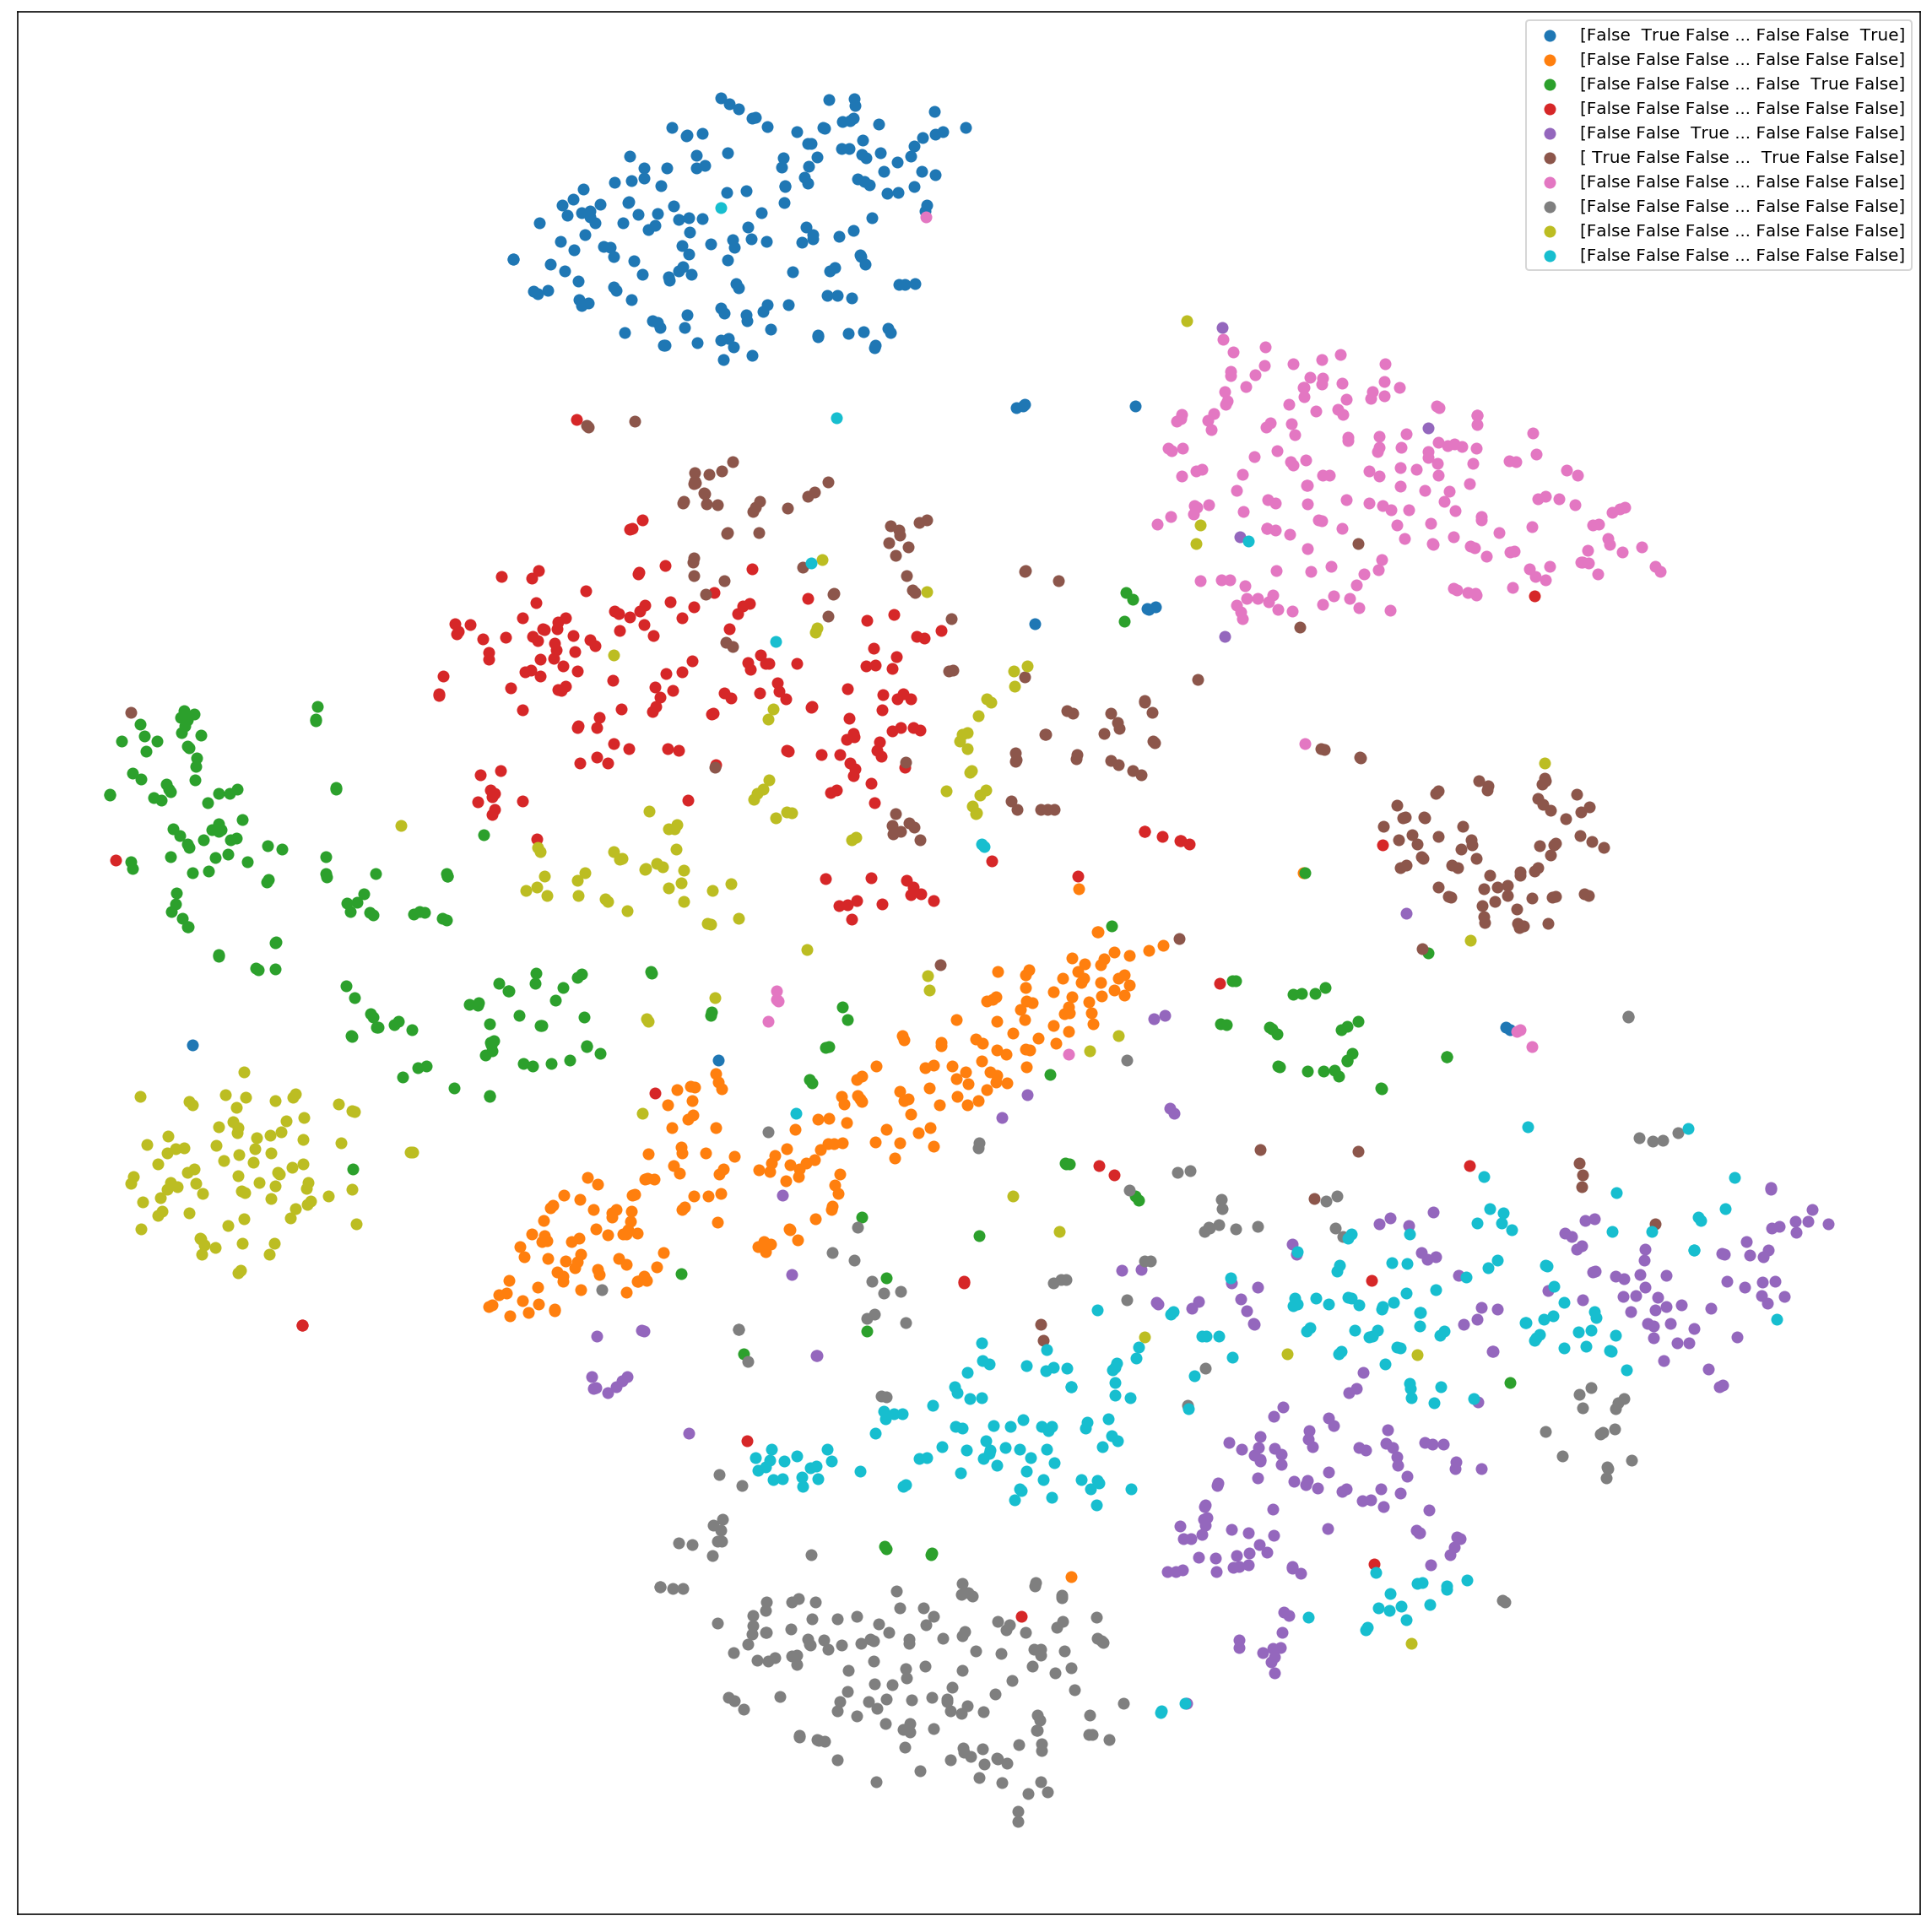

In [33]:
plot_2d_mnist_scatter(X_tsne_embedded, y_small)

### 3D interactive plots with plotly

In [48]:
#!conda install -c plotly chart-studio
!pip install chart-studio
#!conda install -c https://conda.anaconda.org/plotly plotly

In [49]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

def plot_3d_mnist_plotly_scatter(X, y):
    def make_trace(i):
        digit_indeces = y == i
        return go.Scatter3d(
            x=X[digit_indeces, 0],
            y=X[digit_indeces, 1],
            z=X[digit_indeces, 2],
            mode='markers',
            name=str(i),
            marker=dict(
                color=i,
                colorscale='Jet',
                size=4,
                symbol='circle',
                line=dict(
                    color='rgb(204, 204, 204)',
                    width=1
                )
            )
        )
        
    traces = [make_trace(i) for i in range(10)]
    
    layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

ModuleNotFoundError: No module named 'chart_studio'

Use PCA function to embed `X_small` in **three** dimensions. Store the result in `X_3d_pca_embedded`.

In [39]:
pca_3d = PCA(n_components=3)
X_3d_pca_embedded = pca_3d.fit_transform(X_small)

In [40]:
X_3d_pca_embedded.shape

(2000, 3)

In [41]:
plot_3d_mnist_plotly_scatter(X_3d_pca_embedded, y_small)

NameError: name 'plot_3d_mnist_plotly_scatter' is not defined

## Classification task

In [42]:
from sklearn.model_selection import train_test_split
SAMPLES_LIMIT=10000
X_train, X_test, y_train, y_test = train_test_split(X[:SAMPLES_LIMIT], y[:SAMPLES_LIMIT], test_size=0.2)

In [43]:
from sklearn import svm
classifier = svm.SVC(C=1, gamma=0.001)
classifier.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [44]:
from sklearn import metrics

predicted = classifier.predict(X_test)

print("Classification report for classifier {}:\n{}\n".format(
    classifier, metrics.classification_report(y_test, predicted)))

Classification report for classifier SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       200
           1       0.91      0.98      0.94       218
           2       0.90      0.84      0.87       191
           3       0.89      0.87      0.88       214
           4       0.86      0.94      0.89       186
           5       0.85      0.84      0.85       161
           6       0.93      0.95      0.94       206
           7       0.91      0.89      0.90       216
           8       0.92      0.81      0.87       205
           9       0.88      0.89      0.88       203

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0

Calculate and display the confision matrix for `predicted` and `y_test` (use metrics package).

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predicted)

print("Confusion matrix:\n{}".format(confusion_matrix))

Confusion matrix:
[[196   0   1   2   0   0   0   0   1   0]
 [  0 213   1   0   1   3   0   0   0   0]
 [  4   3 160   1   4   2   5   4   7   1]
 [  2   3   6 187   0   7   0   3   2   4]
 [  0   0   0   0 174   0   0   1   1  10]
 [  3   3   0   7   5 136   4   0   3   0]
 [  0   0   2   0   5   3 196   0   0   0]
 [  1   7   3   0   6   0   0 192   0   7]
 [  2   4   3   8   3   9   5   1 167   3]
 [  2   1   1   4   5   0   0  10   0 180]]
